In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from bisect import bisect_left


In [4]:
kuzmin_et_al_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/yeast_screens/KuzminEtAl2018/data_files"
kuzmin_2018_s1 = pd.read_csv(f"{kuzmin_et_al_data_dir}/Data File S1_Raw genetic interaction dataset.tsv", sep="\t")
kuzmin_s2 = pd.read_csv(f"{kuzmin_et_al_data_dir}/Data File S2_Digenic and adjusted trigenic interaction dataset OpenedExportedFromExcel.txt", sep="\t")

kuzmin_2018_s1 = kuzmin_2018_s1.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Raw genetic interaction score (epsilon)": "raw_interaction_score_epsilon",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Query single/double mutant fitness": "query_single_double_mutant_fitness",
                        "Array single mutant fitness": "array_single_mutant_fitness",
                        "Combined mutant fitness": "combined_mutant_fitness",
                        "Combined mutant fitness standard deviation": "combined_mutant_fitness_std"})

kuzmin_2018_s1 = kuzmin_2018_s1[["query_allele_name", 
                        "array_allele_name", 
                        "combined_mutant_type", 
                        "raw_interaction_score_epsilon", 
                        "adjusted_interaction_score_epsilon_or_tau", 
                        "pval", 
                        "query_single_double_mutant_fitness", 
                        "array_single_mutant_fitness", 
                        "combined_mutant_fitness"]]


kuzmin_2018_s1.query_allele_name = kuzmin_2018_s1.query_allele_name.str.replace("Δ","")
kuzmin_2018_s1.array_allele_name = kuzmin_2018_s1.array_allele_name.str.replace("Δ","")

kuzmin_2018_s1[['query1_allele_name', 'query2_allele_name']] = kuzmin_2018_s1.query_allele_name.str.split("+", expand=True)
# combine allele alphanumerically
kuzmin_2018_s1['alleles'] = [','.join(sorted(tup)) for tup in zip(kuzmin_2018_s1.query1_allele_name, kuzmin_2018_s1.query2_allele_name, kuzmin_2018_s1.array_allele_name)]
#kuzmin_2018_s1['query_allele_name_sorted'] = [','.join(sorted(tup)) for tup in zip(kuzmin_2018_s1.query1_allele_name, kuzmin_2018_s1.query2_allele_name)]
#kuzmin_2018_s1 = kuzmin_2018_s1.drop(columns=['query_allele_name'])

kuzmin_2018_s1_trigenic = kuzmin_2018_s1[kuzmin_2018_s1.combined_mutant_type == 'trigenic'].drop(columns=['combined_mutant_type'])
kuzmin_2018_s1_trigenic = kuzmin_2018_s1_trigenic.reset_index(drop=True)

kuzmin_2018_s1_digenic = kuzmin_2018_s1[kuzmin_2018_s1.combined_mutant_type == 'digenic'].drop(columns=['combined_mutant_type'])
kuzmin_2018_s1_digenic.alleles = kuzmin_2018_s1_digenic.alleles.str.replace("ho,","")
kuzmin_2018_s1_digenic.alleles = kuzmin_2018_s1_digenic.alleles.str.replace(",ho","")
kuzmin_2018_s1_digenic = kuzmin_2018_s1_digenic.reset_index(drop=True)

#dict(zip(kuzmin_2018_s1_digenic.array_allele_name, kuzmin_2018_s1_digenic.array_single_mutant_fitness))

kuzmin_2018_s1_digenic.query_allele_name = kuzmin_2018_s1_digenic.query_allele_name.str.replace("\+ho","")
kuzmin_2018_s1_digenic.query_allele_name = kuzmin_2018_s1_digenic.query_allele_name.str.replace("ho\+","")

# make dict of single mutant fitness, dropping keeping the first duplicates b/c all are duplicates
s1 = pd.concat([kuzmin_2018_s1.array_allele_name, kuzmin_2018_s1_digenic.query_allele_name], axis=0)
s2 = pd.concat([kuzmin_2018_s1.array_single_mutant_fitness, kuzmin_2018_s1_digenic.query_single_double_mutant_fitness], axis=0)
df = pd.concat([s1, s2], axis=1).rename(columns={0:"allele", 1:"value"})
kuzmin_2018_singMutFit = dict(zip(df.allele, df.value))

# dbl mutant fitnesses come from digenic crosses and query strain of trigenic crosses
s1 = pd.concat([kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_trigenic.query_allele_name], axis=0) 
s2 = pd.concat([kuzmin_2018_s1_digenic.combined_mutant_fitness, kuzmin_2018_s1_trigenic.query_single_double_mutant_fitness], axis=0)
df = pd.concat([s1, s2], axis=1).rename(columns={0:"allele", 1:"value"})
kuzmin_2018_dblMutFit = dict(zip(df.allele, df.value))

df = pd.concat([kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.adjusted_interaction_score_epsilon_or_tau], axis = 1)
kuzmin_2018_epsilon = dict(zip(df.alleles, df.adjusted_interaction_score_epsilon_or_tau))

print(len(kuzmin_2018_singMutFit))
print(len(kuzmin_2018_dblMutFit))
print(len(kuzmin_2018_epsilon))

1406
396525
396343


In [5]:
kuzmin_2018_s1_digenic

,query_allele_name,array_allele_name,raw_interaction_score_epsilon,adjusted_interaction_score_epsilon_or_tau,pval,query_single_double_mutant_fitness,array_single_mutant_fitness,combined_mutant_fitness,query1_allele_name,query2_allele_name,alleles
0,nup60,gem1,-0.008680,-0.008680,0.43950,0.9528,0.8595,0.8103,nup60,ho,"gem1,nup60"
1,nup60,oaf1,-0.012815,-0.012815,0.41940,0.9528,0.9665,0.9081,nup60,ho,"nup60,oaf1"
2,nup60,flc2,-0.045327,-0.045327,0.26650,0.9528,0.9675,0.8765,nup60,ho,"flc2,nup60"
3,nup60,acs1,-0.022210,-0.022210,0.37030,0.9528,0.9875,0.9187,nup60,ho,"acs1,nup60"
4,nup60,pex22,-0.029287,-0.029287,0.33580,0.9528,0.8713,0.8009,nup60,ho,"nup60,pex22"
...,...,...,...,...,...,...,...,...,...,...,...
410394,ski3,sec8-9,-0.069336,-0.069336,0.02908,0.9346,0.9211,0.7915,ski3,ho,"sec8-9,ski3"
410395,ski3,brr1,0.042359,0.042359,0.30760,0.9346,0.7907,0.7813,ski3,ho,"brr1,ski3"
410396,ski3,rox1,-0.010273,-0.010273,0.44220,0.9346,0.9890,0.9140,ski3,ho,"rox1,ski3"
410397,ski3,med1,0.105338,0.105338,0.19500,0.9346,0.7060,0.7651,ski3,ho,"med1,ski3"


In [6]:
costanzo_et_al_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/yeast_screens/CostanzoEtAl2016/data_files/Data File S1. Raw genetic interaction datasets: Pair-wise interaction format"

costanzo_nxn = pd.read_csv(f"{costanzo_et_al_data_dir}/SGA_NxN.txt", sep="\t")
costanzo_exn = pd.read_csv(f"{costanzo_et_al_data_dir}/SGA_ExN.txt", sep="\t")
costanzo_exe = pd.read_csv(f"{costanzo_et_al_data_dir}/SGA_ExE.txt", sep="\t")


costanzo_data_column_rename = {"Query Strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array Strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Arraytype/Temp" : "Arraytype_Temp",
                        "Genetic interaction score (ε)" : "genetic_interaction_e",
                        "P-value": "pval",
                        "Query single mutant fitness (SMF)": "query_smf",
                        "Array SMF": "array_smf",
                        "Double mutant fitness": "dbl_mutant_fitness",
                        "Double mutant fitness standard deviation": "dbl_mutant_fitness_std"}

costanzo_nxn = costanzo_nxn.rename(columns = costanzo_data_column_rename)
costanzo_exn = costanzo_exn.rename(columns = costanzo_data_column_rename)
costanzo_exe = costanzo_exe.rename(columns = costanzo_data_column_rename)
costanzo = pd.concat([costanzo_nxn, costanzo_exn, costanzo_exe])

costanzo = costanzo.astype({'query_strain_id': 'str',
                    'query_allele_name': 'str',
                    'array_strain_id': 'str',
                    'array_allele_name': 'str',
                    'Arraytype_Temp': 'str'})

costanzo = costanzo[['query_allele_name', 'array_allele_name', 'query_smf', 'array_smf', 'dbl_mutant_fitness']]
# this solution is really fast

costanzo['alleles'] = [','.join(sorted(tup)) for tup in zip(costanzo.query_allele_name, costanzo.array_allele_name)]


costanzo = costanzo.reset_index(drop=True)
#costanzo.head()

s1 = pd.concat([costanzo.query_allele_name, costanzo.array_allele_name], axis=0)
s2 = pd.concat([costanzo.query_smf, costanzo.array_smf], axis=0)
df = pd.concat([s1, s2], axis=1).rename(columns={0:"allele", 1:"value"})
df = df.drop_duplicates(subset=["allele"], keep='first').reset_index(drop=True)
costanzo_singMutFit = dict(zip(df.allele, df.value))

df = pd.concat([costanzo.alleles, costanzo.dbl_mutant_fitness], axis = 1)
df = df.drop_duplicates(subset=["alleles"], keep=False).reset_index(drop=True)
costanzo_dblMutFit = dict(zip(df.alleles, df.dbl_mutant_fitness))

print(len(costanzo_singMutFit))
print(len(costanzo_dblMutFit))

5647
8562870


Consider three genes i, j, and k. Based on the experimental design of Kuzmin et al, they compute digenic interaction effects between genes i and k (e_ik) and between genes j and k (e_jk). Then, they cross the double mutant ij with single mutant k. This cross introduces 3 interaction effects: 2 digenic (e_ik and e_jk) and 1 trigenic (t_ijk). They compute the trigenic effect by subtracting out the two previously calculated digenic effects. Note that e_ij isn't calculated here and is irrelevant.

For each triple mutant ijk, let's confirm that double mutants ik and jk exist:

In [7]:

f_ij, f_ik, f_jk = defaultdict(), defaultdict(), defaultdict()
f_i, f_j, f_k = defaultdict(), defaultdict(), defaultdict()
e_ik_kuz, e_jk_kuz = defaultdict(), defaultdict()

for i, row in kuzmin_2018_s1_trigenic.iterrows():
    #if i <= 100:
        alleles = row['alleles'].split(",")

        ij = ",".join(sorted([alleles[0],alleles[1]]))
        ik = ",".join(sorted([alleles[0],alleles[2]]))
        jk = ",".join(sorted([alleles[1],alleles[2]]))

        i,j,k = alleles[0], alleles[1], alleles[2]
       
        try:
            f_ij[row['alleles']] = kuzmin_2018_dblMutFit[ij]
        except KeyError:
            f_ij[row['alleles']] = float('nan')
        try:
            f_ik[row['alleles']] = kuzmin_2018_dblMutFit[ik]
        except KeyError:
            f_ik[row['alleles']] = float('nan')
        try:
            f_jk[row['alleles']] = kuzmin_2018_dblMutFit[jk]
        except KeyError:
            f_jk[row['alleles']] = float('nan')
        
        
        # get single mutant fitnesses

        try:
            f_i[row['alleles']] = costanzo_singMutFit[i]
        except KeyError:
            try:
                f_i[row['alleles']] = kuzmin_2018_singMutFit[i]
            except:
                f_i[row['alleles']] = float('nan')
       
        try:
            f_j[row['alleles']] = costanzo_singMutFit[j]
        except KeyError:
            try:
                f_j[row['alleles']] = kuzmin_2018_singMutFit[j]
            except:
                f_j[row['alleles']] = float('nan')
       
        try:
            f_k[row['alleles']] = costanzo_singMutFit[k]
        except KeyError:
            try:
                f_k[row['alleles']] = kuzmin_2018_singMutFit[k]
            except:
                f_k[row['alleles']] = float('nan')
                
       # get pairwise epistasis
        try:
            e_ik_kuz[row['alleles']] = kuzmin_2018_epsilon[ik]
        except KeyError:
            e_ik_kuz[row['alleles']] = float('nan')

        try:
            e_jk_kuz[row['alleles']] = kuzmin_2018_epsilon[jk]
        except KeyError:
            e_jk_kuz[row['alleles']] = float('nan')

kuzmin_2018_s1_trigenic['f_ij'] = kuzmin_2018_s1_trigenic['alleles'].map(f_ij)
kuzmin_2018_s1_trigenic['f_ik'] = kuzmin_2018_s1_trigenic['alleles'].map(f_ik)
kuzmin_2018_s1_trigenic['f_jk'] = kuzmin_2018_s1_trigenic['alleles'].map(f_jk)

kuzmin_2018_s1_trigenic['f_i'] = kuzmin_2018_s1_trigenic['alleles'].map(f_i)
kuzmin_2018_s1_trigenic['f_j'] = kuzmin_2018_s1_trigenic['alleles'].map(f_j)
kuzmin_2018_s1_trigenic['f_k'] = kuzmin_2018_s1_trigenic['alleles'].map(f_k)

kuzmin_2018_s1_trigenic['e_ik_kuz'] = kuzmin_2018_s1_trigenic['alleles'].map(e_ik_kuz)
kuzmin_2018_s1_trigenic['e_jk_kuz'] = kuzmin_2018_s1_trigenic['alleles'].map(e_jk_kuz)



In [8]:


print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.f_ij)))
print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.f_ik)))
print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.f_jk)))
print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.f_i)))
print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.f_j)))
print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.f_k)))
print()
print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.e_ik_kuz)))
print(np.sum(~np.isnan(kuzmin_2018_s1_trigenic.e_jk_kuz)))

#print(len(kuzmin_2020_s1_trigenic.f_ik))
print(len(kuzmin_2018_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
print(len(kuzmin_2018_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
print(len(kuzmin_2018_s1_trigenic))
print(len(kuzmin_2018_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(kuzmin_2018_s1_trigenic))

80357
76867
75129
89461
88813
89316

76867
75129
48403
48403
91111
0.5312530868940084


<ipython-input-9-415bab9d6a0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau_kuzmin2'] = df.combined_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij
<ipython-input-9-415bab9d6a0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau_kuzmin1'] = df.combined_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i
<ipython-input-9-415bab9d6a0b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,tau_kuzmin1,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin1,1.00000,0.34463
adjusted_interaction_score_epsilon_or_tau,0.34463,1.00000


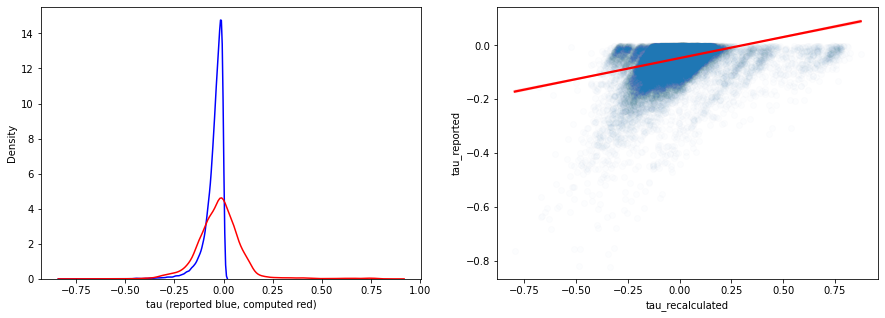

In [9]:
kuzmin_2018_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])

df = kuzmin_2018_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])
df['tau_kuzmin2'] = df.combined_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij
df['tau_kuzmin1'] = df.combined_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i
# substituting double mutant fitness with multiplicative model and epistasis values
df['tau_kuzmin3'] = df.combined_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*(df.f_j*df.f_k + df.e_jk_kuz) - df.f_j*(df.f_i*df.f_k + df.e_ik_kuz) - df.f_k*df.f_ij

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin1'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df['tau_kuzmin1'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')

df[['tau_kuzmin1', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")
#kuzmin_2020_s1_trigenic[['tau_kuzmin2', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")
#kuzmin_2020_s1_trigenic[['tau_kuzmin2', 'tau_kuzmin1']].corr(method="pearson")

In [135]:
kuzmin_2018_s1_trigenic

,array_allele_name,raw_interaction_score_epsilon,adjusted_interaction_score_epsilon_or_tau,pval,query_single_double_mutant_fitness,array_single_mutant_fitness,combined_mutant_fitness,query1_allele_name,query2_allele_name,alleles,query_allele_name_sorted,f_ij,f_ik,f_jk,f_i,f_j,f_k,e_ik_kuz,e_jk_kuz
0,acs1,0.022001,-0.033056,0.393700,0.5128,0.9875,0.5284,nup60,pml39,"acs1,nup60,pml39","nup60,pml39",0.9187,0.8467,0.6731,0.9875,0.9772,1.0228,0.077267,NaN
1,pex22,0.047924,-0.010328,0.266100,0.5128,0.8713,0.4947,nup60,pml39,"nup60,pex22,pml39","nup60,pml39",0.8009,0.6731,0.7664,0.9772,0.8713,1.0228,NaN,0.087539
2,sla1,0.087312,-0.055782,0.088980,0.5128,0.8230,0.5093,nup60,pml39,"nup60,pml39,sla1","nup60,pml39",0.6731,0.9191,0.6494,0.9772,1.0228,0.8230,0.134918,0.008176
3,hir1,-0.030342,-0.017200,0.376300,0.5128,0.9370,0.4501,nup60,pml39,"hir1,nup60,pml39","nup60,pml39",0.8741,0.7357,0.6731,0.9370,0.9772,1.0228,0.005597,NaN
4,hap3,-0.034534,-0.069190,0.372200,0.5128,0.8615,0.4072,nup60,pml39,"hap3,nup60,pml39","nup60,pml39",0.8982,0.6286,0.6731,0.8615,0.9772,1.0228,-0.042670,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91106,rpl43a,-0.064435,-0.023764,0.324700,0.9196,0.4963,0.3920,ski3,ski8,"rpl43a,ski3,ski8","ski3,ski8",0.4752,0.4074,0.9791,0.4963,0.9647,0.9325,-0.052063,NaN
91107,mcm16,0.039255,-0.076493,0.292400,0.9196,1.0125,0.9704,ski3,ski8,"mcm16,ski3,ski8","ski3,ski8",1.0008,0.9984,0.9791,1.0125,0.9647,0.9325,0.061172,NaN
91108,brr1,0.126958,-0.000058,0.000003,0.9196,0.7907,0.8541,ski3,ski8,"brr1,ski3,ski8","ski3,ski8",0.7813,0.8166,0.9791,0.7907,0.9647,0.9325,0.084657,NaN
91109,rox1,-0.184603,-0.152884,0.103600,0.9196,0.9890,0.7249,ski3,ski8,"rox1,ski3,ski8","ski3,ski8",0.9140,0.8941,0.9791,0.9890,0.9647,0.9325,NaN,NaN
